In [2]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, Layer, LeakyReLU
from tensorflow.keras import Model
from itertools import combinations
import datetime
# for types hints
from typing import Tuple, Callable, List, Optional
from tensorflow import Tensor
from numpy import ndarray

Synthetic Data

In [3]:
# 4 input values, each Gaussian distributed with 0 mean and 1 stdev
# 1 output value, distance from the origin, AKA L2-norm
# 1000 instances for training, 1000 for testing

In [4]:
def create_synthetic_data(n_train=1000, n_test=1000, n_features=4):
    """
    Create a synthetic regression dataset.
    The input features (X) are randomly generated using a normal distribution centered at 0 with a standard deviation of 1.
    The target values (y) are calculated as the L2 norm (Euclidean norm) of the input features.

    :param n_train: Number of training instances.
    :param n_test: Number of testing instances.
    :param n_features: Number of input features.
    :return: X_train, y_train, X_test, y_test
    """

    # Create training data
    X_train = np.random.normal(loc=0, scale=1, size=(n_train, n_features))
    y_train = np.linalg.norm(X_train, axis=1)  # Compute the L2-norm
    # Create testing data
    X_test = np.random.normal(loc=0, scale=1, size=(n_test, n_features))
    y_test = np.linalg.norm(X_test, axis=1)  # Compute the L2-norm


    return X_train, y_train, X_test, y_test

In [5]:
def normalize_labels(y: np.ndarray) -> np.ndarray:
    """
    Normalize the target values so they are between 0 and 2 using the equation:
    y' = 2 * (y - min) / (max - min)

    :param y: The original target values.
    :return: The normalized target values.
    """
    # print shape of y
    print(y.shape)
    min_val = np.min(y)
    print('min_val y in before norm: ', min_val)
    max_val = np.max(y)
    print('max_val y in before norm: ', max_val)
    
    # Normalize the labels
    normalized_y = 2 * (y - min_val) / (max_val - min_val)
    
    return normalized_y

In [6]:
# Generate the synthetic data
X_train, y_train, X_test, y_test = create_synthetic_data()
# print 5 first elements in X_train
print(X_train[:5])
# print 5 first elements in X_test
print(X_test[:5])
# print 5 first elements in y_train
print(y_train[:5])
# Normalize the labels
y_train = normalize_labels(y_train)
# print 5 first elements in y_train
print(y_train[:5])
# print 5 first elements in y_test
print(y_test[:5])
y_test = normalize_labels(y_test)
# print 5 first elements in y_test
print(y_test[:5])

[[-1.73202216  0.44518165  0.02392529 -0.52150751]
 [-0.21248192  0.98400681  0.70054221  0.45607437]
 [ 0.66532105  0.79605726 -0.27631903 -0.6371806 ]
 [-0.91330374 -0.43360798 -0.65088329  2.79554536]
 [-0.08129348 -0.64441526  0.51698731  0.72994954]]
[[ 1.20694701 -1.02891427  0.74850574  0.42756872]
 [ 0.66191249  1.59814951 -0.10970759 -1.06884898]
 [-1.42885975  1.0447071  -0.7665262   0.24450833]
 [-1.00779191 -1.27374707 -0.97990247  0.05269185]
 [ 0.00293313  0.81105274 -0.46520407  0.65682037]]
[1.86296269 1.30850341 1.24848332 3.04316652 1.10543289]
(1000,)
min_val y in before norm:  0.2016668888258397
max_val y in before norm:  4.840610858252229
[0.71623879 0.47719331 0.45131669 1.22506314 0.38964299]
[1.80512091 2.03634081 1.94432503 1.89764629 1.14264735]
(1000,)
min_val y in before norm:  0.09183730760048077
max_val y in before norm:  4.137578204888615
[0.84695666 0.96125954 0.91577181 0.89269631 0.51946483]


In [7]:
# Sanity check if y values are between 0 and 2
print(f"Min y_train: {np.min(y_train)}")
print(f"Max y_train: {np.max(y_train)}")

Min y_train: 0.0
Max y_train: 2.0


Model Building

In [8]:
# NN for representation learning:
# 4 input nodes
# 1 or more hidden layers
# the last hidden layer has 2 nodes (representation layer Z)
# plot the instances in the 2D feature/representation space of Z 
# use different colors for different target values (can be in groups, each group with a different color) similar to the RankSim pictures
# training and test sets in different plots.
# expecting the instances to be in a semi-circle
# for prediction, add output layer of 1 node.


In [9]:
def create_model(hiddens: List[int]) -> Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = Dense(nodes)(x)
        x = LeakyReLU()(x) # Replacing 'relu' activation with LeakyReLU
    # Define the representation layer (Z features)
    repr_layer = Dense(2)(x)
    repr_layer = LeakyReLU(name='repr_layer')(repr_layer) # Replacing 'relu' activation with LeakyReLU
    # Normalize the representation layer to fit on the unit circle
    # repr_layer = Lambda(lambda z: z / tf.norm(z, axis=1, keepdims=True))(x)
    # Define the output layer for fitting to the label
    pred_output = Dense(1, name='pred_output')(repr_layer)
    # Bundle the Z features and fitting output into a model
    model = Model(inputs=inputs, outputs=[pred_output]) #, repr_layer])


    return model



In [10]:
def get_groups(y: List[float]) -> Tuple[List[int], int, int]:
    """
    Find the minimum and maximum values in the dataset and create a list of integer groups between those values.

    :param y: The target values in the dataset.
    :return: A list of integer groups between the minimum and maximum values
    :return: The minimum value in the dataset.
    :return: The maximum value in the dataset.
    """
    min_val = int(min(y))
    max_val = int(max(y))
    
    return list(range(min_val, max_val + 1)), min_val, max_val


In [11]:
def plot_feature_space(model: Model, data: ndarray, labels: ndarray, groups: Optional[List[int]] = None):
    """
    Plot the instances in the 2D feature space of the representation layer (Z).

    :param model: Trained neural network model.
    :param data: Input data, shape of [num_instances, num_features].
    :param labels: Corresponding labels for the data.
    :param groups: Optional grouping for labels to define color assignment.
    """
    # Extract the representation layer from the model
    repr_layer_model = Model(inputs=model.input, outputs=model.output)

    # Predict the representation for the input data
    repr_space = repr_layer_model.predict(data)

    # If groups are defined, categorize labels into groups
    if groups:
        group_labels = [np.digitize(label, groups) for label in labels]
    else:
        group_labels = labels

    # Create a scatter plot for the representation space
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(repr_space[:, 0], repr_space[:, 1], c=group_labels, cmap='viridis')
    plt.colorbar(scatter)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('2D Feature Space of Representation Layer')
    plt.xlim(-1, 1)  # Limit x-axis to range of -1 to 1
    plt.ylim(-1, 1)  # Limit y-axis to range of -1 to 1
    plt.show()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0     

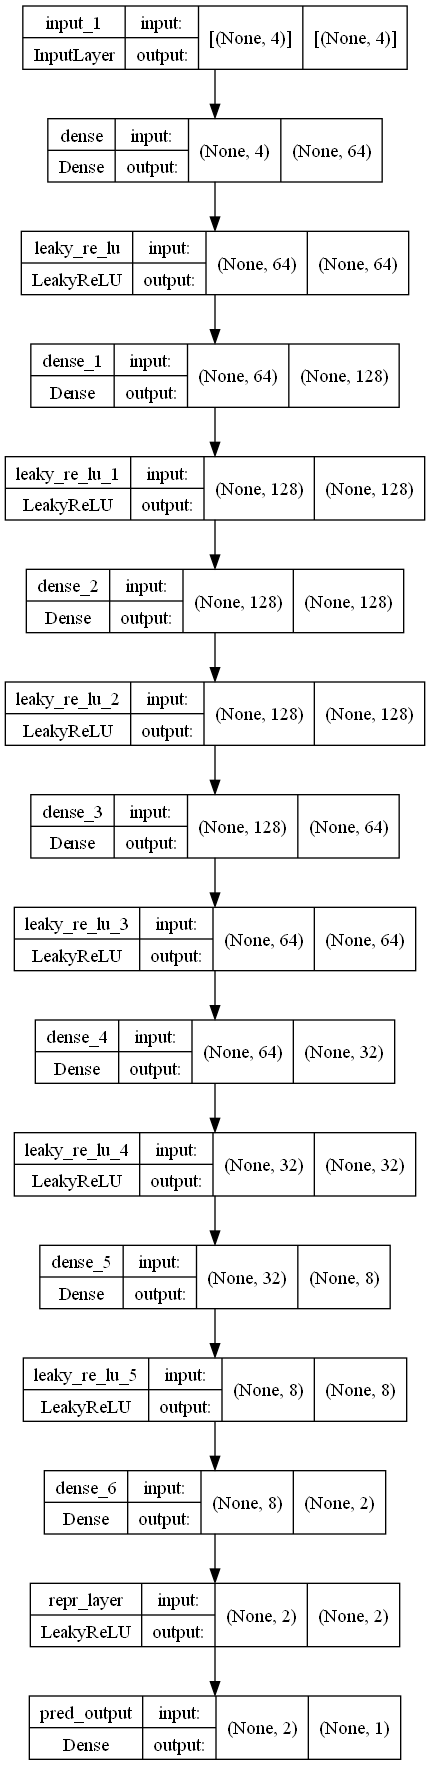

In [12]:
# Create and train the model
hiddens = [64, 128, 128, 64, 32, 8]
model = create_model(hiddens)
# summarize and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# # Plot the 2D feature space
# plot_feature_space(model, X_train, y_train)
# plot_feature_space(model, X_test, y_test)

Epoch 1/10
32/32 [==============================] - 2s 5ms/step - loss: 0.0691
Epoch 2/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0047
Epoch 3/10
32/32 [==============================] - 0s 5ms/step - loss: 0.0013
Epoch 4/10
32/32 [==============================] - 0s 5ms/step - loss: 3.8270e-04
Epoch 5/10
32/32 [==============================] - 0s 5ms/step - loss: 2.0663e-04
Epoch 6/10
32/32 [==============================] - 0s 5ms/step - loss: 1.5560e-04
Epoch 7/10
32/32 [==============================] - 0s 6ms/step - loss: 1.2263e-04
Epoch 8/10
32/32 [==============================] - 0s 5ms/step - loss: 1.1635e-04
Epoch 9/10
32/32 [==============================] - 0s 5ms/step - loss: 1.1613e-04
Epoch 10/10
32/32 [==============================] - 0s 5ms/step - loss: 1.0595e-04
Groups: [0, 1, 2, 3], Min: 0, Max: 3


Test of First Idea improving on ranksim

In [14]:
def zdist(vec1: Tensor, vec2: Tensor) -> float:
    """
    Computes the squared L2 norm distance between two input feature vectors.

    :param vec1: The first input feature vector.
    :param vec2: The second input feature vector.
    :return: The squared L2 norm distance.
    """
    return tf.reduce_sum(tf.square(vec1 - vec2))


def ydist(val1: float, val2: float) -> float:
    """
    Computes the squared distance between two label values.

    :param val1: The first label value.
    :param val2: The second label value.
    :return: The squared distance.
    """
    return (val1 - val2) ** 2

def error(z1: Tensor, z2: Tensor, label1: float, label2: float) -> float:
    """
    Computes the error between the zdist of two input predicted z values and their ydist.
    Range of the error is [0, 16].

    :param z1: The predicted z value for the first input sample.
    :param z2: The predicted z value for the second input sample.
    :param label1: The label of the first input sample.
    :param label2: The label of the second input sample.
    :return: The squared difference between the zdist and ydist.
    """
    squared_difference = (zdist(z1, z2) - ydist(label1, label2)) ** 2
    return tf.reduce_sum(squared_difference)


def custom_loss(y_true, z_pred, reduction=tf.keras.losses.Reduction.SUM):
    """
    Computes the loss for a batch of predicted features and their labels.
    
    :param y_true: A batch of true label values, shape of [batch_size, 1].
    :param z_pred: A batch of predicted Z values, shape of [batch_size, 2].
    :param reduction: The type of reduction to apply to the loss.
    :return: The average error for all unique combinations of the samples in the batch.
    """
    int_batch_size = tf.shape(z_pred)[0]
    batch_size = tf.cast(int_batch_size, dtype=tf.float32)
    total_error = tf.constant(0.0, dtype=tf.float32)

    # Loop through all unique pairs of samples in the batch
    for i in tf.range(int_batch_size):
        for j in tf.range(i + 1, int_batch_size):
            z1, z2 = z_pred[i], z_pred[j]
            # tf.print(z1, z2, sep=', ', end='\n')
            label1, label2 = y_true[i], y_true[j]
            # tf.print(label1, label2, sep=', ', end='\n')
            err = error(z1, z2, label1, label2)
            # tf.print(err, end='\n\n')
            total_error += tf.cast(err, dtype=tf.float32)
    
    # tf.print(total_error)
    
    if reduction == tf.keras.losses.Reduction.SUM:
        return total_error # total loss
    elif reduction == tf.keras.losses.Reduction.NONE:
        denom = tf.cast(batch_size * (batch_size - 1) / 2 + 1e-9, dtype=tf.float32)
        # tf.print(denom)
        return total_error / denom # average loss
    else:
        raise ValueError(f"Unsupported reduction type: {reduction}.")


In [15]:
# loss mindful sanity check
# Create a batch of 3 samples
y_true = tf.constant([[1.0], [2.0], [0.0]])
z_pred = tf.constant([[0.0, 1.0], [0.552027583, 0.833825886], [0.0, 0.0]])

# find all unique pair indices
pairs = list(combinations(range(3), 2))
print(pairs)
# compute zdist and ydist for each pair
for i, j in pairs:
    print(i, j)
    print(z_pred[i], z_pred[j])
    print(zdist(z_pred[i], z_pred[j]))
    print(y_true[i], y_true[j])
    print(ydist(y_true[i], y_true[j]))
    print(error(z_pred[i], z_pred[j], y_true[i], y_true[j]))
    
# compute the average loss
print(custom_loss(y_true, z_pred))


[(0, 1), (0, 2), (1, 2)]
0 1
tf.Tensor([0. 1.], shape=(2,), dtype=float32) tf.Tensor([0.5520276 0.8338259], shape=(2,), dtype=float32)
tf.Tensor(0.3323483, shape=(), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([2.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor(0.44575882, shape=(), dtype=float32)
0 2
tf.Tensor([0. 1.], shape=(2,), dtype=float32) tf.Tensor([0. 0.], shape=(2,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32) tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([1.], shape=(1,), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
1 2
tf.Tensor([0.5520276 0.8338259], shape=(2,), dtype=float32) tf.Tensor([0. 0.], shape=(2,), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor([2.], shape=(1,), dtype=float32) tf.Tensor([0.], shape=(1,), dtype=float32)
tf.Tensor([4.], shape=(1,), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(9.445759,

In [16]:
class NormalizeLayer(Layer):
    def __init__(self, epsilon: float = 1e-9, **kwargs):
        """
        Initialization for the NormalizeLayer.

        :param epsilon: A small constant to prevent division by zero during normalization. Default is 1e-9.
        :param kwargs: Additional keyword arguments for the parent class.
        """
        self.epsilon = epsilon
        super(NormalizeLayer, self).__init__(**kwargs)

    def call(self, inputs: Tensor) -> Tensor:
        """
        Forward pass for the NormalizeLayer.

        :param inputs: Input tensor of shape [batch_size, ...].
        :return: Normalized input tensor of the same shape as inputs.
        """
        norm = tf.norm(inputs, axis=1, keepdims=True) + self.epsilon
        return inputs / norm

    def get_config(self) -> dict:
        """
        Returns the config of the layer. Contains the layer's configuration as a dict,
        including the `epsilon` parameter and the configurations of the parent class.

        :return: A dict containing the layer's configuration.
        """
        config = super().get_config()
        config.update({
            "epsilon": self.epsilon,
        })
        return config


In [17]:
def create_model_feat(hiddens: List[int]) -> Model:
    """
    Create a neural network model with two branches using the Keras functional API.
    One branch will be used for fitting the output to the label, and the other will use the Z features for the custom loss.
    The Z features are normalized to fit on the unit circle.

    :param hiddens: List of integers representing the number of nodes in each hidden layer.
    :return: The uncompiled model.
    """
    inputs = Input(shape=(4,))
    x = inputs
    # Define hidden layers according to architecture
    for nodes in hiddens:
        x = Dense(nodes)(x)
        x = LeakyReLU()(x)
     # Define the representation layer (Z features)
    x = Dense(2)(x)
    x = LeakyReLU()(x)
    # Normalize the representation layer to fit on the unit circle
    repr_layer = NormalizeLayer()(x)
    # Bundle the Z features and fitting output into a model
    enc_model = Model(inputs=inputs, outputs=repr_layer)

    return enc_model


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_7 (Dense)             (None, 64)                320       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 128)               16512     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128)               0   

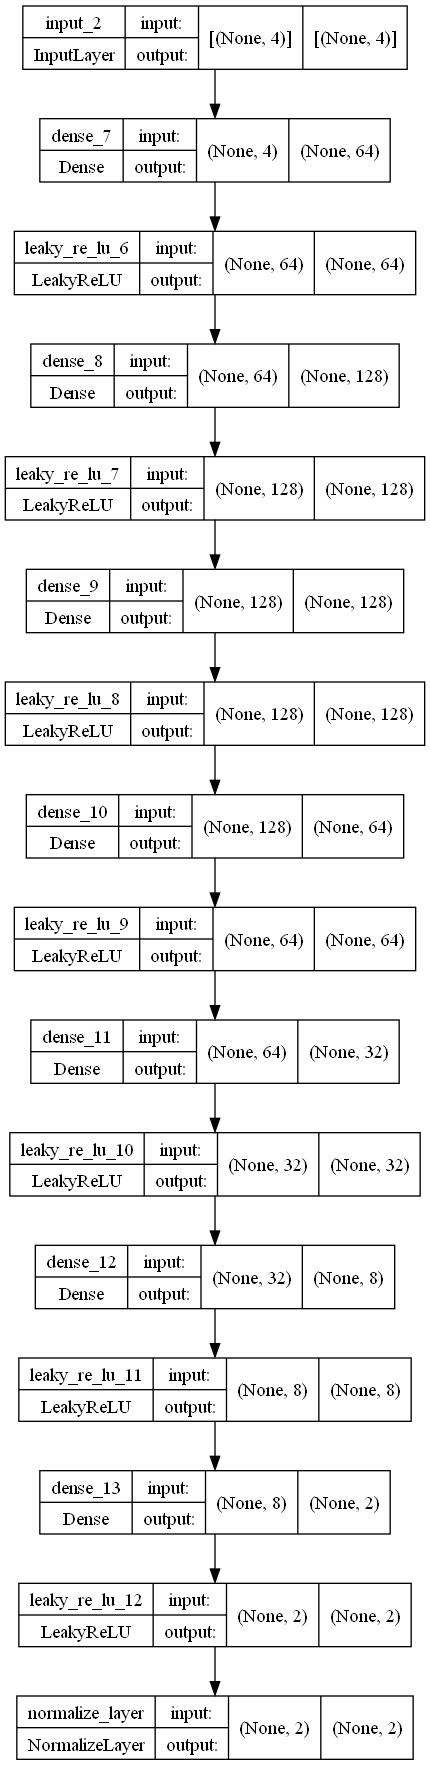

In [18]:
# Create and train the model
model_feat = create_model_feat(hiddens)
# summarize and plot the model
model_feat.summary()
tf.keras.utils.plot_model(model_feat, show_shapes=True)

In [19]:
model_feat.compile(optimizer='adam', loss=custom_loss)

[0.9999998  0.9999999  0.99999994 1.         1.0000001 ]


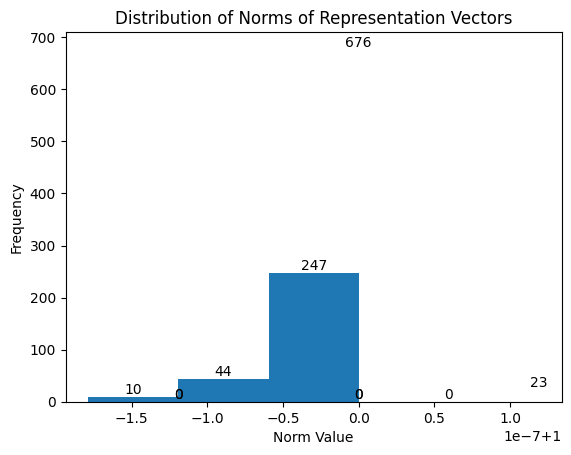

In [20]:
# mindful sanity check of the model output being normalized
reprs = model_feat.predict(X_train)
# Calculate the norms of the representation vectors
norms = np.linalg.norm(reprs, axis=1)
# Find all unique norm values
unique_norms = np.unique(norms)
# Print or otherwise use the unique norm values
print(unique_norms)
# Plot a histogram of the norms and get the patches to annotate
n, bins, patches = plt.hist(norms)

# Iterate through the patches to annotate each bar
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             patches[i].get_height(), 
             str(int(n[i])),
             ha='center', 
             va='bottom')
plt.title('Distribution of Norms of Representation Vectors')
plt.xlabel('Norm Value')
plt.ylabel('Frequency')
plt.show()



In [21]:
# setup tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)
# tensorboard --logdir logs/fit

In [22]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss)
history = model_feat.fit(X_train, y_train, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])  

Epoch 1/400
50/50 [==============================] - 9s 152ms/step - loss: 10.7871 - val_loss: 7.7122
Epoch 2/400
50/50 [==============================] - 7s 146ms/step - loss: 9.6390 - val_loss: 5.4011
Epoch 3/400
50/50 [==============================] - 7s 146ms/step - loss: 4.1646 - val_loss: 1.5217
Epoch 4/400
50/50 [==============================] - 7s 144ms/step - loss: 2.7711 - val_loss: 3.3997
Epoch 5/400
50/50 [==============================] - 7s 145ms/step - loss: 2.5171 - val_loss: 1.4022
Epoch 6/400
50/50 [==============================] - 7s 134ms/step - loss: 1.4170 - val_loss: 0.8741
Epoch 7/400
50/50 [==============================] - 7s 135ms/step - loss: 0.8309 - val_loss: 0.6430
Epoch 8/400
50/50 [==============================] - 7s 140ms/step - loss: 0.5108 - val_loss: 0.5466
Epoch 9/400
50/50 [==============================] - 8s 150ms/step - loss: 1.4290 - val_loss: 1.0325
Epoch 10/400
50/50 [==============================] - 7s 146ms/step - loss: 1.4279 - val_l

Groups: [0, 1, 2, 3], Min: 0, Max: 3


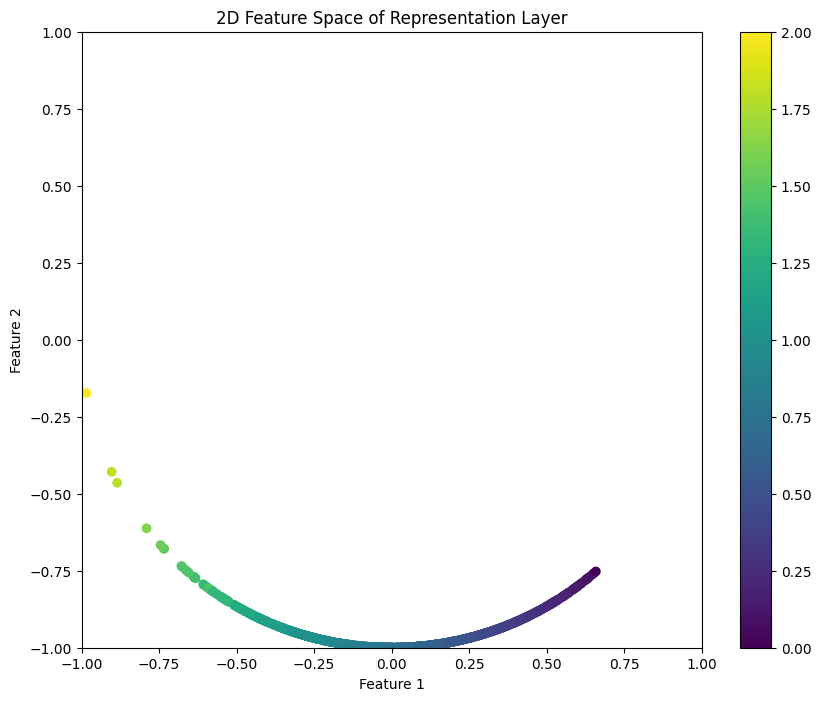

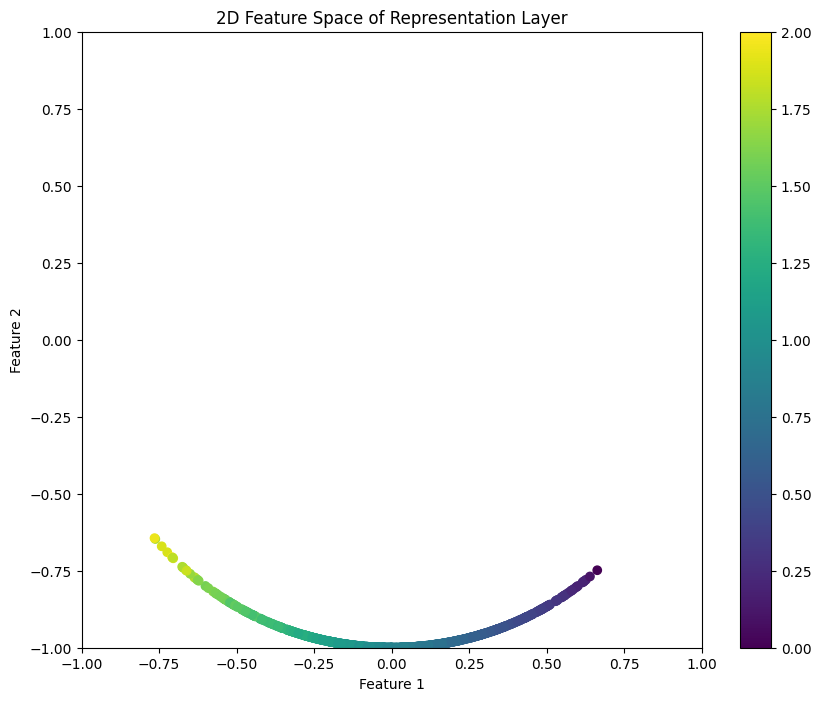

In [23]:
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat, X_train, y_train)
plot_feature_space(model_feat, X_test, y_test)

In [24]:
# finetuning with lower learning rate
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss=custom_loss)
history = model_feat.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])

Epoch 1/200
50/50 [==============================] - 9s 151ms/step - loss: 0.0569 - val_loss: 0.0843
Epoch 2/200
50/50 [==============================] - 7s 143ms/step - loss: 0.0519 - val_loss: 0.0837
Epoch 3/200
50/50 [==============================] - 7s 137ms/step - loss: 0.0563 - val_loss: 0.0834
Epoch 4/200
50/50 [==============================] - 7s 141ms/step - loss: 0.0419 - val_loss: 0.0832
Epoch 5/200
50/50 [==============================] - 7s 140ms/step - loss: 0.0466 - val_loss: 0.0833
Epoch 6/200
50/50 [==============================] - 7s 136ms/step - loss: 0.0401 - val_loss: 0.0831
Epoch 7/200
50/50 [==============================] - 7s 139ms/step - loss: 0.0452 - val_loss: 0.0830
Epoch 8/200
50/50 [==============================] - 7s 141ms/step - loss: 0.0516 - val_loss: 0.0828
Epoch 9/200
50/50 [==============================] - 7s 148ms/step - loss: 0.0532 - val_loss: 0.0827
Epoch 10/200
50/50 [==============================] - 7s 139ms/step - loss: 0.0377 - val_lo

Groups: [0, 1, 2, 3], Min: 0, Max: 3


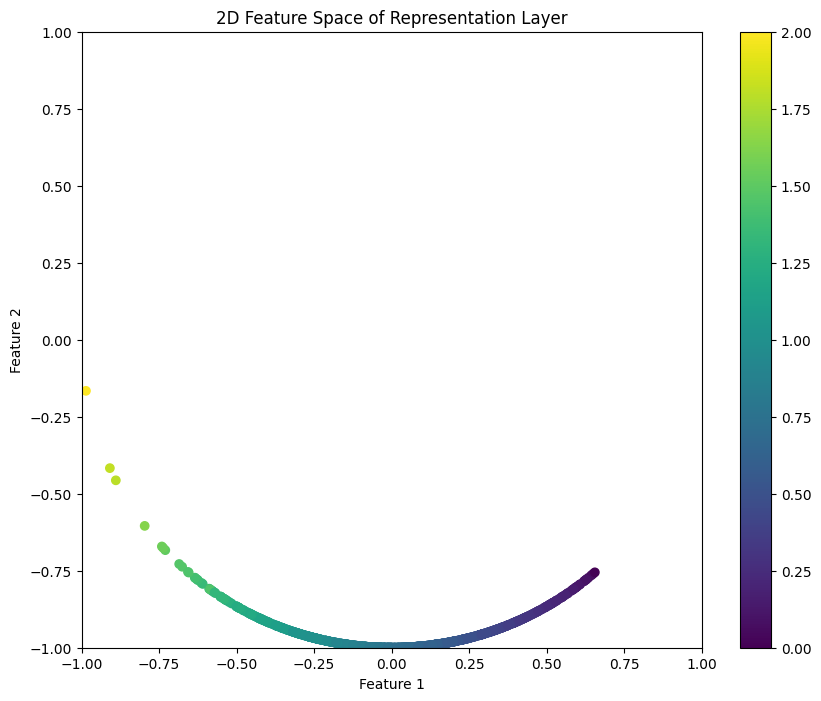

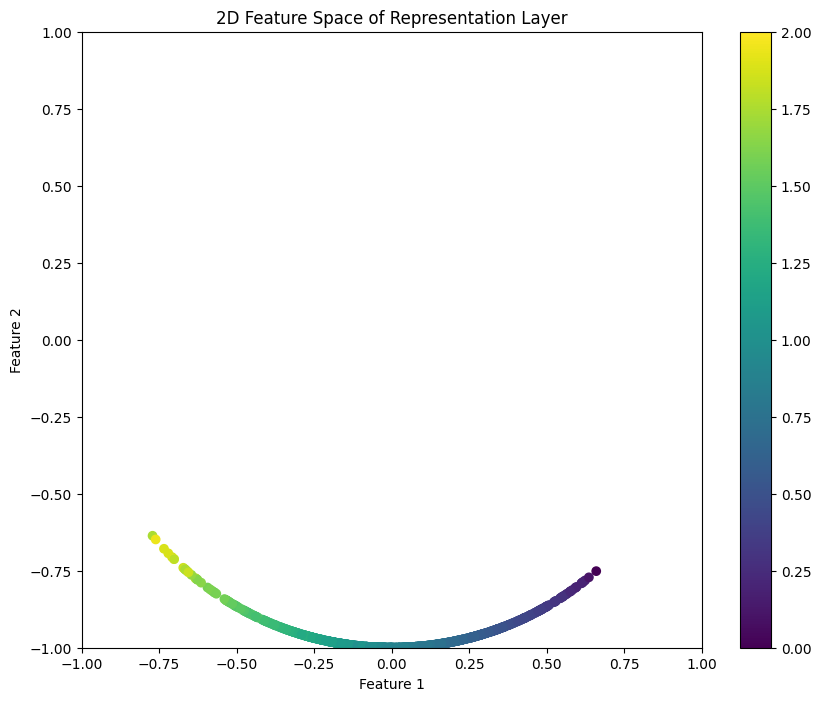

In [25]:
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat, X_train, y_train)
plot_feature_space(model_feat, X_test, y_test)

In [26]:
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=custom_loss)
history = model_feat.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=[tensorboard_cb])

Epoch 1/25
63/63 [==============================] - 12s 162ms/step - loss: 0.1103
Epoch 2/25
63/63 [==============================] - 10s 154ms/step - loss: 0.0749
Epoch 3/25
63/63 [==============================] - 10s 156ms/step - loss: 0.0771
Epoch 4/25
63/63 [==============================] - 10s 152ms/step - loss: 0.0655
Epoch 5/25
63/63 [==============================] - 10s 155ms/step - loss: 0.0602
Epoch 6/25
63/63 [==============================] - 10s 161ms/step - loss: 0.0447
Epoch 7/25
63/63 [==============================] - 10s 160ms/step - loss: 0.0606
Epoch 8/25
63/63 [==============================] - 10s 157ms/step - loss: 0.0885
Epoch 9/25
63/63 [==============================] - 10s 156ms/step - loss: 0.0622
Epoch 10/25
63/63 [==============================] - 10s 155ms/step - loss: 0.0736
Epoch 11/25
63/63 [==============================] - 10s 163ms/step - loss: 0.0733
Epoch 12/25
63/63 [==============================] - 10s 163ms/step - loss: 0.0963
Epoch 13/25
6

Groups: [0, 1, 2, 3], Min: 0, Max: 3


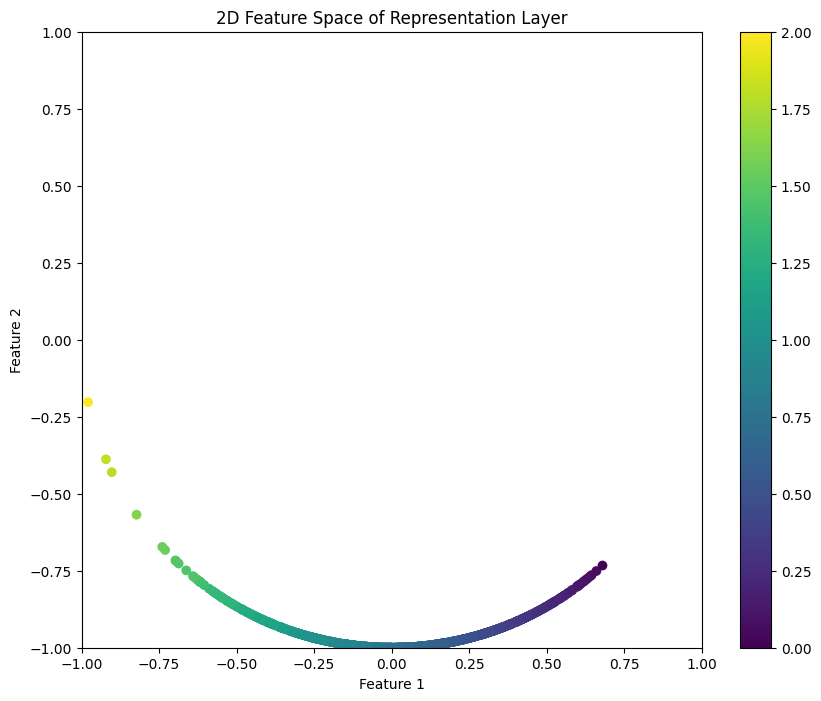

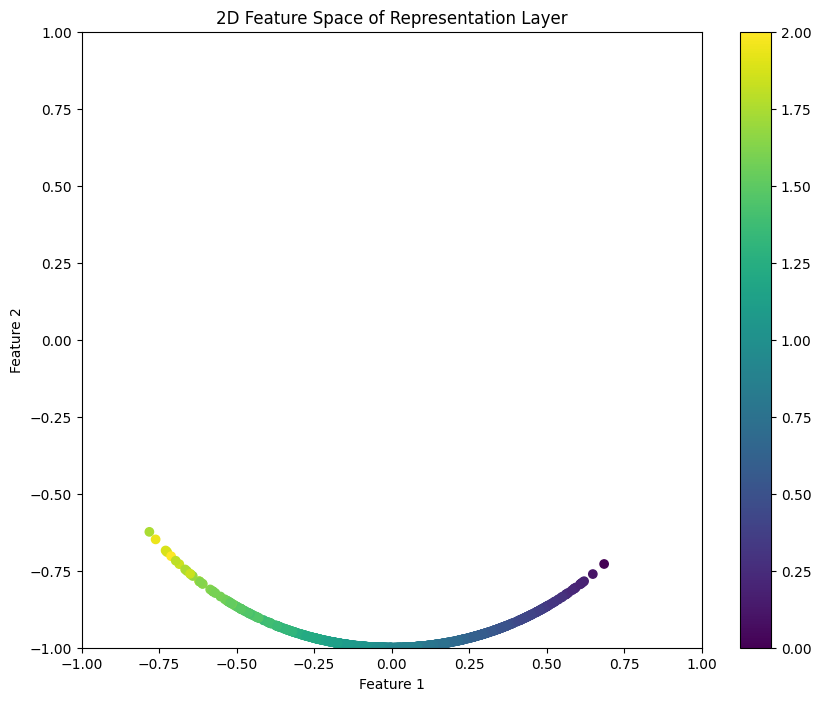

In [27]:
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat, X_train, y_train)
plot_feature_space(model_feat, X_test, y_test)


In [31]:
# Find the indices of the 10 smallest values in y_train
indices_of_smallest = np.argsort(y_test)[:10]

# Print the inputs, features, and target values for the 10 instances
for index in indices_of_smallest:
    print("Inputs:", X_test[index])
    print("Target Value:", y_test[index])
    print("Feature Value:", model_feat.predict(X_test[index:index+1])) 
    print("---")


Inputs: [ 0.03897117  0.04579688  0.01955912 -0.06659899]
Target Value: 0.0
Feature Value: [[ 0.6854418 -0.7281274]]
---
Inputs: [-0.12060095 -0.18412222  0.02647119 -0.2128977 ]
Target Value: 0.10654426294012936
Feature Value: [[ 0.6489094  -0.76086575]]
---
Inputs: [ 0.18850981 -0.25561453 -0.17293038  0.26754089]
Target Value: 0.1769785336685878
Feature Value: [[ 0.62082005 -0.78395313]]
---
Inputs: [-0.40294912 -0.13749816 -0.15623178 -0.14291465]
Target Value: 0.18966586839946858
Feature Value: [[ 0.6137631  -0.78949034]]
---
Inputs: [ 0.11433603 -0.03062449 -0.00562318 -0.46749956]
Target Value: 0.19301626101388838
Feature Value: [[ 0.6093379 -0.7929107]]
---
Inputs: [0.09501338 0.40910385 0.07596354 0.24766752]
Target Value: 0.19854118384963074
Feature Value: [[ 0.61177516 -0.79103166]]
---
Inputs: [ 0.00245814 -0.37291642 -0.32852583  0.14389195]
Target Value: 0.21037759110545046
Feature Value: [[ 0.5944164 -0.8041574]]
---
Inputs: [ 0.39104272 -0.32062278 -0.11043878  0.031685

In [32]:
# Find the indices of the 10 largest values in y_test
indices_of_largest = np.argsort(y_test)[-10:]

# Print the inputs, features, and target values for the 10 instances
for index in indices_of_largest:
    print("Inputs:", X_test[index])
    print("Target Value:", y_test[index])
    print("Feature Value:", model_feat.predict(X_test[index:index+1])) 
    print("---")


Inputs: [-0.05197896 -2.47165316 -0.05422679  2.66780564]
Target Value: 1.7528212825927958
Feature Value: [[-0.6660738 -0.7458859]]
---
Inputs: [ 1.90907029  0.65843755 -2.06390159 -2.25543764]
Target Value: 1.7658800673888828
Feature Value: [[-0.620813  -0.7839587]]
---
Inputs: [ 0.98992442 -1.61617884  3.12975538  0.74744024]
Target Value: 1.8007083651351714
Feature Value: [[-0.6965619 -0.7174968]]
---
Inputs: [-0.32625976  1.37667387 -2.58209277  2.41262209]
Target Value: 1.836344324309982
Feature Value: [[-0.6851601 -0.7283925]]
---
Inputs: [ 1.4911182   0.8693079  -3.38181021  0.3037899 ]
Target Value: 1.8375409108772147
Feature Value: [[-0.6502095 -0.759755 ]]
---
Inputs: [-3.03516811  0.10053969 -0.24796832  2.34295851]
Target Value: 1.8546750372354333
Feature Value: [[-0.7266028  -0.68705785]]
---
Inputs: [ 3.82207177 -0.24505575  0.70740221  0.04269683]
Target Value: 1.8800505093476518
Feature Value: [[-0.72937727 -0.6841118 ]]
---
Inputs: [-1.12203156 -1.52574912 -0.95086553 

In [33]:
# let's find the count per bins 
def count_samples_in_bins(y_values: ndarray):
    """
    Count the number of samples whose target values are in bins.
    The bins are defined by intervals of 0.1 from 0 to 2.

    :param y_values: A numpy array containing target values.
    :return: None, but prints the count per bin along with the range of the bin.
    """
    # Define the bins
    bins = np.arange(0, 2.1, 0.1)
    
    # Count the samples in each bin
    hist, _ = np.histogram(y_values, bins)
    
    # Output the count and range for each bin
    for i in range(len(bins) - 1):
        print(f"Bin {i} ({bins[i]:.1f} to {bins[i+1]:.1f}): {hist[i]} samples")

In [34]:
# Count the samples in each bin for the test set
count_samples_in_bins(y_test)
# This confirms that the test set is normally distributed around .9 where 
# both values very close to 0 and 2 are very rare so they are separated in feature space
# Why values close to zero are as rare?
# when considering the standard gaussian density function,
# to have a norm close to zero, you need to have all 4 features close to zero
# which means the interval over which the density function is integrated is very small
# the bins reflect that.

Bin 0 (0.0 to 0.1): 1 samples
Bin 1 (0.1 to 0.2): 5 samples
Bin 2 (0.2 to 0.3): 16 samples
Bin 3 (0.3 to 0.4): 42 samples
Bin 4 (0.4 to 0.5): 52 samples
Bin 5 (0.5 to 0.6): 86 samples
Bin 6 (0.6 to 0.7): 82 samples
Bin 7 (0.7 to 0.8): 99 samples
Bin 8 (0.8 to 0.9): 148 samples
Bin 9 (0.9 to 1.0): 123 samples
Bin 10 (1.0 to 1.1): 96 samples
Bin 11 (1.1 to 1.2): 81 samples
Bin 12 (1.2 to 1.3): 64 samples
Bin 13 (1.3 to 1.4): 38 samples
Bin 14 (1.4 to 1.5): 27 samples
Bin 15 (1.5 to 1.6): 20 samples
Bin 16 (1.6 to 1.7): 6 samples
Bin 17 (1.7 to 1.8): 6 samples
Bin 18 (1.8 to 1.9): 6 samples
Bin 19 (1.9 to 2.0): 2 samples


In [35]:
# Count the samples in each bin for the training set
count_samples_in_bins(y_train)

Bin 0 (0.0 to 0.1): 5 samples
Bin 1 (0.1 to 0.2): 24 samples
Bin 2 (0.2 to 0.3): 43 samples
Bin 3 (0.3 to 0.4): 75 samples
Bin 4 (0.4 to 0.5): 95 samples
Bin 5 (0.5 to 0.6): 120 samples
Bin 6 (0.6 to 0.7): 140 samples
Bin 7 (0.7 to 0.8): 126 samples
Bin 8 (0.8 to 0.9): 102 samples
Bin 9 (0.9 to 1.0): 81 samples
Bin 10 (1.0 to 1.1): 82 samples
Bin 11 (1.1 to 1.2): 53 samples
Bin 12 (1.2 to 1.3): 23 samples
Bin 13 (1.3 to 1.4): 16 samples
Bin 14 (1.4 to 1.5): 8 samples
Bin 15 (1.5 to 1.6): 3 samples
Bin 16 (1.6 to 1.7): 1 samples
Bin 17 (1.7 to 1.8): 1 samples
Bin 18 (1.8 to 1.9): 1 samples
Bin 19 (1.9 to 2.0): 1 samples


In [ ]:
# why are the green and yellow points mixed up?
# mixup happens mostly for large values of y (close to 2), rare samples
# no mixup in training set feature space but mixup in test set feature space for rare samples
# this might be due to imbalance for rare sample
# TODO: test it with balanced dataset

In [47]:
def augment_data(X: Tensor, y: Tensor, threshold: float=1.5, n_augment: int=500):
    """
    Augment the dataset by generating synthetic points interpolated between existing points with L2 norm > threshold.

    :param X: Input features, shape [n_samples, n_features].
    :param y: Target values, shape [n_samples].
    :param threshold: L2 norm threshold for identifying rare samples to augment.
    :param n_augment: Number of synthetic points to generate.
    :return: Augmented dataset (X_augmented, y_augmented).
    """
    # Identify indices of points with L2 norm greater than the threshold
    high_norm_indices = np.where(y > threshold)[0]
    # Initialize lists to store augmented data
    X_augment = []
    y_augment = []

    # Generate synthetic points
    for _ in range(n_augment):
        # Randomly choose two data points from the high_norm_indices
        idx1, idx2 = np.random.choice(high_norm_indices, 2, replace=False)

        # Generate a random interpolation factor
        alpha = np.random.rand()

        # Create synthetic point
        x_new = alpha * X[idx1] + (1 - alpha) * X[idx2]
        y_new = np.linalg.norm(x_new)

        X_augment.append(x_new)
        y_augment.append(y_new)

    # Convert lists to NumPy arrays
    X_augment = np.array(X_augment)
    y_augment = np.array(y_augment)
    
    # Normalize the labels
    y_augment = normalize_labels(y_augment)

    # Combine original and augmented data
    X_augmented = np.vstack((X, X_augment))
    y_augmented = np.hstack((y, y_augment))

    return X_augmented, y_augmented

In [48]:
X_train_aug, y_train_aug = augment_data(X_train, y_train, n_augment=600)
# printing number of elements in X_train_aug, y_train_aug
print(len(X_train_aug), len(y_train_aug))
# counting samples in bins for augmented data
count_samples_in_bins(y_train_aug)
# printing min and max values in y_train_aug
print(f"Min y_train_aug: {np.min(y_train_aug)}")
print(f"Max y_train_aug: {np.max(y_train_aug)}")

(600,)
min_val y in before norm:  0.9268337425070367
max_val y in before norm:  4.829625407012725
1600 1600
Bin 0 (0.0 to 0.1): 15 samples
Bin 1 (0.1 to 0.2): 27 samples
Bin 2 (0.2 to 0.3): 53 samples
Bin 3 (0.3 to 0.4): 95 samples
Bin 4 (0.4 to 0.5): 121 samples
Bin 5 (0.5 to 0.6): 151 samples
Bin 6 (0.6 to 0.7): 176 samples
Bin 7 (0.7 to 0.8): 152 samples
Bin 8 (0.8 to 0.9): 124 samples
Bin 9 (0.9 to 1.0): 96 samples
Bin 10 (1.0 to 1.1): 100 samples
Bin 11 (1.1 to 1.2): 71 samples
Bin 12 (1.2 to 1.3): 76 samples
Bin 13 (1.3 to 1.4): 63 samples
Bin 14 (1.4 to 1.5): 68 samples
Bin 15 (1.5 to 1.6): 50 samples
Bin 16 (1.6 to 1.7): 52 samples
Bin 17 (1.7 to 1.8): 65 samples
Bin 18 (1.8 to 1.9): 21 samples
Bin 19 (1.9 to 2.0): 24 samples
Min y_train_aug: 0.0
Max y_train_aug: 2.0


In [49]:
# Create and train the model
model_feat_aug = create_model_feat(hiddens)
model_feat_aug.compile(optimizer='adam', loss=custom_loss)

In [50]:
# setup tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
model_feat_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=custom_loss)
history = model_feat_aug.fit(X_train_aug, y_train_aug, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb]) 

Epoch 1/400
80/80 [==============================] - 14s 147ms/step - loss: 18.5122 - val_loss: 15.4857
Epoch 2/400
80/80 [==============================] - 12s 144ms/step - loss: 8.2605 - val_loss: 17.5946
Epoch 3/400
80/80 [==============================] - 11s 139ms/step - loss: 5.6088 - val_loss: 13.2949
Epoch 4/400
80/80 [==============================] - 11s 137ms/step - loss: 3.6993 - val_loss: 6.1986
Epoch 5/400
80/80 [==============================] - 11s 139ms/step - loss: 2.9004 - val_loss: 6.4278
Epoch 6/400
80/80 [==============================] - 12s 152ms/step - loss: 2.2231 - val_loss: 3.9952
Epoch 7/400
80/80 [==============================] - 12s 145ms/step - loss: 1.7477 - val_loss: 5.7770
Epoch 8/400
80/80 [==============================] - 11s 143ms/step - loss: 2.7935 - val_loss: 6.1600
Epoch 9/400
80/80 [==============================] - 11s 140ms/step - loss: 2.2313 - val_loss: 11.2664
Epoch 10/400
80/80 [==============================] - 10s 131ms/step - loss: 

In [ ]:
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train_aug + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat_aug, X_train_aug, y_train_aug)
plot_feature_space(model_feat_aug, X_test, y_test)

In [ ]:
# finetuning with lower learning rate
model_feat_aug.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6), loss=custom_loss)
history = model_feat_aug.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])

In [ ]:
# get groupings for the labels
groups, min_val, max_val = get_groups(y_train_aug + y_test)
print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# Plot the 2D feature space
plot_feature_space(model_feat_aug, X_train_aug, y_train_aug)
plot_feature_space(model_feat_aug, X_test, y_test)